# Índice
* [Scraping](../scraper/Web-scraping.ipynb)
* [Limpieza y Feature engineering](../limpieza/Limpieza-y-exploracion-de-datos-no-estructurados-con-spark.ipynb)
* [Modelado](#Modelado)

# Modelado

## Objetivo

**Predecir precios de venta de casas en San Francisco**

- Los **datos**: Zillow. Información de casas en diferentes zonas, el precio y fecha en que se vendieron y el precio que se puso en los anuncios.
- Variable a predecir: **lastsoldprice**.
- El dataset tbn incluye zestimate: el valor estimado de venta que calculó Zillow pero no lo vamos a tomar en cuenta.
- Haremos un análisis exploratorio brevísimo, una regresión lineal y un bosque aleatorio.

In [1]:
# Importamos librerías para trabajar
%matplotlib inline
import numpy as np
import pandas as pd
np.random.seed(66) # Importante para hacer los resultados reproducibles!!!
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# Leemos el csv de datos
sf = pd.read_csv('final_data.csv')
sf.head()

,Unnamed: 0,address,info,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zindexvalue,zipcode,zpid
0,2,Address: 1160 Mission Street #2007,San FranciscoSales price: 1300000Sales date: ...,1160 Mission St UNIT 2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,1167508.0,"975,700",94103.0,83152781.0
1,5,Address: 260 King Street #475,San FranciscoSales price: 750000Sales date: 0...,260 King St UNIT 475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,823719.0,"975,700",94107.0,69819817.0
2,7,Address: 560 Missouri Street #B,San FranciscoSales price: 1495000Sales date: ...,560 Missouri St # B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,1708594.0,"1,277,600",94107.0,64972847.0
3,9,Address: 350 Missouri Street,San FranciscoSales price: 2700000Sales date: ...,350 Missouri St,3.0,3.0,2231.0,02/17/2016,2700000.0,37.761886,-122.396769,Potrero Hill,10.0,SingleFamily,1927.0,2411236.0,"1,277,600",94107.0,15149489.0
4,11,Address: 3658 Folsom Street,San FranciscoSales price: 1530000Sales date: ...,3658 Folsom St,3.0,3.0,1300.0,02/17/2016,1530000.0,37.740795,-122.413453,Bernal Heights,4.0,SingleFamily,1900.0,1918539.0,"1,248,000",94110.0,15161978.0


In [3]:
# Contamos renglones y columnas
sf.shape

(11330, 19)

In [4]:
# Tiramos algunas columnas que no necesitaremos para modelar
# info,z_address,usecode,zipcode: vamos a considerar sólo neighborhood para indicarnos dónde está la casa.
# recordemos que zestimate es el valor estimado por Zillow. No lo queremos incluir en el modelo y tbn lo quitamos.
sf.drop(sf.columns[[0, 2, 3, 15, 17, 18]], axis=1, inplace=True)
sf.head()

,address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zindexvalue
0,Address: 1160 Mission Street #2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,"975,700"
1,Address: 260 King Street #475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,"975,700"
2,Address: 560 Missouri Street #B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,"1,277,600"
3,Address: 350 Missouri Street,3.0,3.0,2231.0,02/17/2016,2700000.0,37.761886,-122.396769,Potrero Hill,10.0,SingleFamily,1927.0,"1,277,600"
4,Address: 3658 Folsom Street,3.0,3.0,1300.0,02/17/2016,1530000.0,37.740795,-122.413453,Bernal Heights,4.0,SingleFamily,1900.0,"1,248,000"


In [5]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11330 entries, 0 to 11329
Data columns (total 13 columns):
address          11330 non-null object
bathrooms        11330 non-null float64
bedrooms         11330 non-null float64
finishedsqft     11330 non-null float64
lastsolddate     11330 non-null object
lastsoldprice    11330 non-null float64
latitude         11330 non-null float64
longitude        11330 non-null float64
neighborhood     11330 non-null object
totalrooms       11330 non-null float64
usecode          11330 non-null object
yearbuilt        11330 non-null float64
zindexvalue      11330 non-null object
dtypes: float64(8), object(5)
memory usage: 1.1+ MB


In [6]:
# Vemos que la variable zindexvalue tiene comas! es texto!!! No puede entrar así al modelo. Casteamos
sf['zindexvalue'] = sf['zindexvalue'].str.replace(',', '')
sf['zindexvalue'] = sf['zindexvalue'].convert_objects(convert_numeric=True)

/home/jess/.pyenv/versions/3.6.0/envs/fintech/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Estadísticos resumen de  variables numéricas
sf.describe()

,bathrooms,bedrooms,finishedsqft,lastsoldprice,latitude,longitude,totalrooms,yearbuilt,zindexvalue
count,11330.000000,11330.000000,11330.000000,1.133000e+04,11330.000000,11330.000000,11330.000000,11330.000000,1.133000e+04
mean,1.980229,2.614475,1585.420918,1.263928e+06,37.759711,-122.436518,6.111562,1948.498147,1.320205e+06
std,1.047358,1.299457,921.978245,1.042079e+06,0.025578,0.030743,12.125819,37.911196,5.848170e+05
min,0.500000,0.000000,1.000000,5.350000e+02,37.708170,-122.510726,1.000000,1860.000000,6.881000e+05
25%,1.000000,2.000000,1019.000000,7.292500e+05,37.739286,-122.455157,4.000000,1916.000000,9.829000e+05
50%,2.000000,2.000000,1362.000000,9.900000e+05,37.760513,-122.432510,5.000000,1940.000000,1.211900e+06
75%,2.000000,3.000000,1876.000000,1.450000e+06,37.781386,-122.413359,7.000000,1986.000000,1.480400e+06
max,14.000000,20.000000,27275.000000,2.388900e+07,37.806083,-122.381201,1264.000000,2016.000000,5.333500e+06


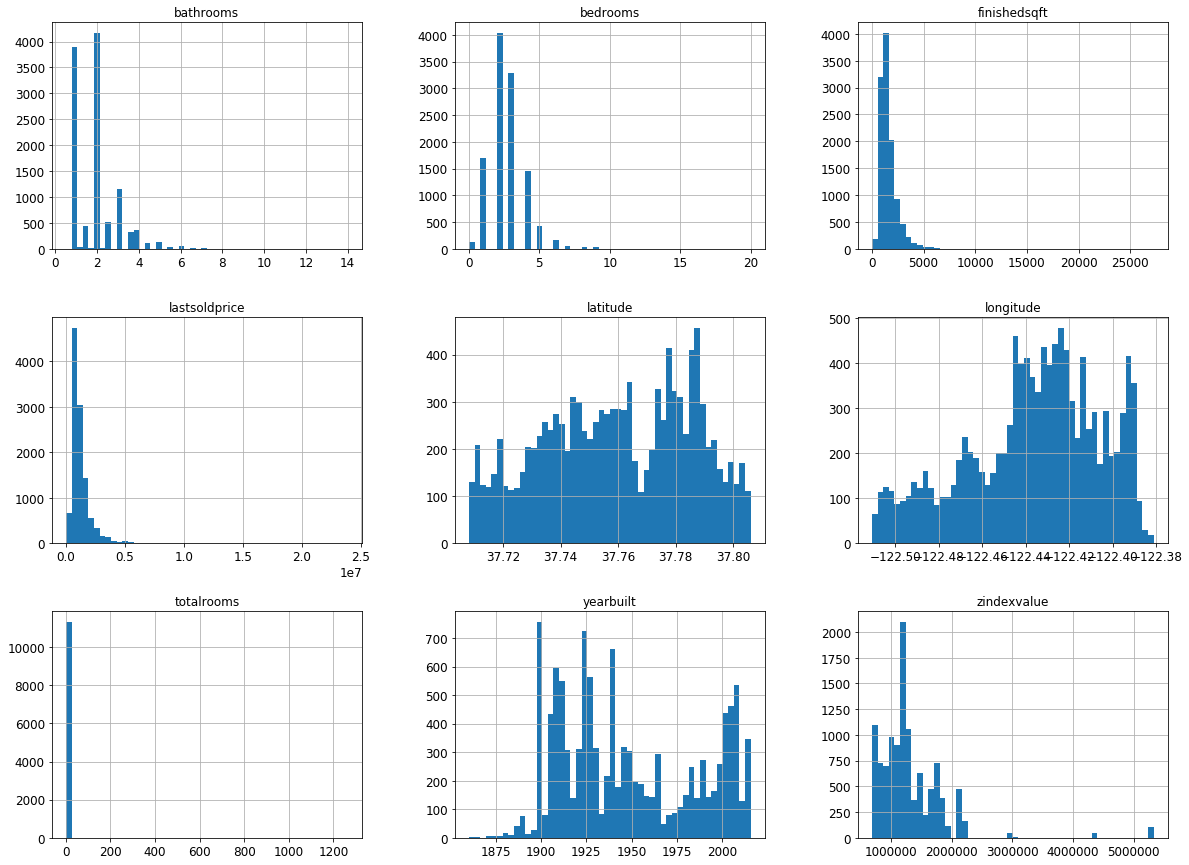

In [8]:
#Histogramas para ver qué hay en cada columna numérica
%matplotlib inline
import matplotlib.pyplot as plt
sf.hist(bins=50, figsize=(20,15))
# Podemos guardar la gráfica en un .png para poder usarla en presentaciones o pdfs
plt.savefig("attribute_histogram_plots")
plt.show()

# Variables tienen diferente escala
# Sesgo puede dificultar que los modelos funcionen; cosas con distribuciones normales funcionan mejor

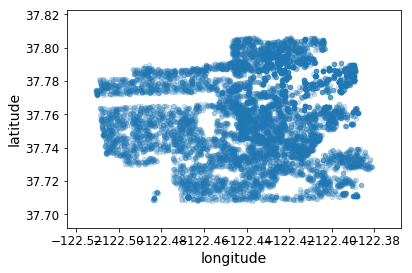

In [9]:
# Tenemos latitud y longitud. Podemos pintar un scatterplot tal cual
sf.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
plt.savefig('map1.png')

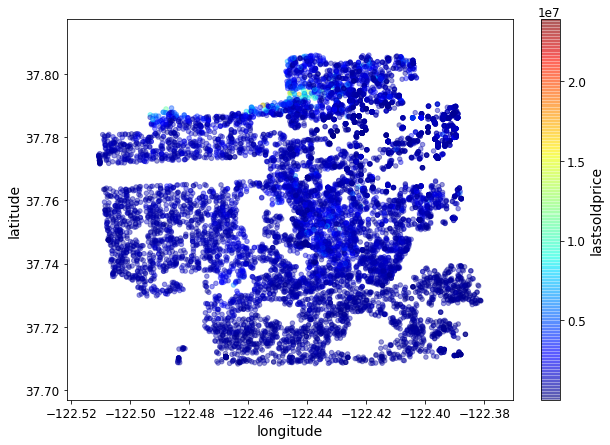

In [10]:
# Podemos pintar puntos en relación con el precio, que es lo que queremos predecir
sf.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7),
    c="lastsoldprice", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.savefig('map2.png')
# OJO! Podemos tener mapas más bonitos con plotly y mapbox

In [11]:
# Correlaciones del lastsoldprice contra todo

corr_matrix = sf.corr()
corr_matrix["lastsoldprice"].sort_values(ascending=False)

# finishedsqft y número de bathrooms tienen corr positiva y grande con lastsoldprice
# Hay corr negativa con yearbuilt pero chica
# Entre más cercano a cero, menor correlación linear

lastsoldprice    1.000000
finishedsqft     0.647208
bathrooms        0.536880
zindexvalue      0.460429
bedrooms         0.395478
latitude         0.283107
totalrooms       0.093527
longitude       -0.052595
yearbuilt       -0.189055
Name: lastsoldprice, dtype: float64

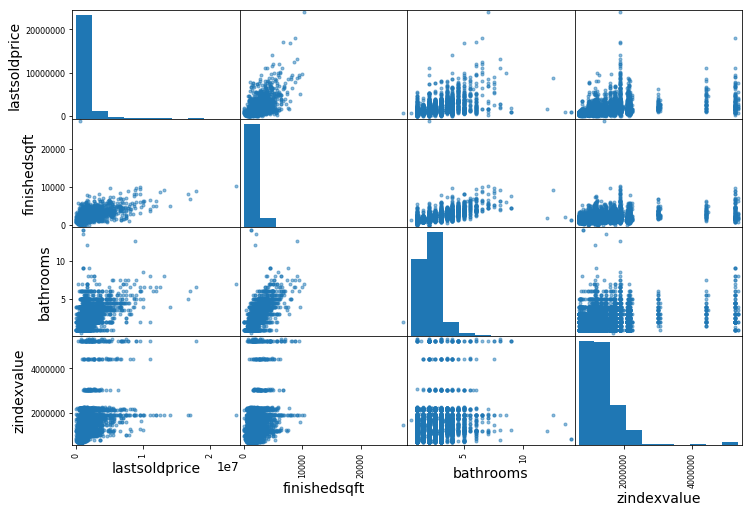

In [12]:
# Elegimos las variables que se ven más correlacionadas con lastsoldprice y pintamos un scatterplot
from pandas.tools.plotting import scatter_matrix

attributes = ["lastsoldprice", "finishedsqft", "bathrooms", "zindexvalue"]
scatter_matrix(sf[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

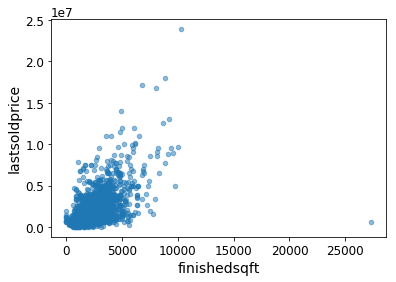

In [13]:
# Lo que mejor se ve es lastsoldprice y finishedsqft
sf.plot(kind="scatter", x="finishedsqft", y="lastsoldprice", alpha=0.5)
plt.savefig('scatter.png')

In [14]:
# OJO, cada casa tiene diferentes metros cuadradas. Casas más grandes seguro son más caras.
# Para poder comparar diferentes casas, necesitamos normalizar: precios por metro cuadrado
sf['price_per_sqft'] = sf['lastsoldprice']/sf['finishedsqft']
corr_matrix = sf.corr()
corr_matrix["lastsoldprice"].sort_values(ascending=False)

lastsoldprice     1.000000
finishedsqft      0.647208
bathrooms         0.536880
zindexvalue       0.460429
bedrooms          0.395478
latitude          0.283107
totalrooms        0.093527
price_per_sqft    0.005008
longitude        -0.052595
yearbuilt        -0.189055
Name: lastsoldprice, dtype: float64

In [15]:
# La variable nueva (price_per_sqft) no tiene muy buena correlación con la que queremos predecir (lastsoldprice)
# Quizá si agrupamos por neighbourhood salgan mejor los modelos
len(sf['neighborhood'].value_counts())

71

In [16]:
# Tiene sentido que el precio por metro cuadrado varíe por zona
# veamos cuántas casas hay por neighborhood
freq = sf.groupby('neighborhood').count()['address']
# Y veamos el precio promedio para cada una de ellas
mean = sf.groupby('neighborhood').mean()['price_per_sqft']
# creamos un dataset nuevo
cluster = pd.concat([freq, mean], axis=1)
cluster['neighborhood'] = cluster.index
cluster.columns = ['freq', 'price_per_sqft','neighborhood']
cluster.head()

,freq,price_per_sqft,neighborhood
neighborhood,,,
Bayview,354,417.049058,Bayview
Bernal Heights,525,3158.199830,Bernal Heights
Buena Vista Park,70,952.912618,Buena Vista Park
Central Richmond,227,659.691461,Central Richmond
Central Sunset,229,610.067525,Central Sunset


In [17]:
# Y veamos resumen de las variables
cluster.describe()

,freq,price_per_sqft
count,71.000000,71.000000
mean,159.577465,1664.908308
std,126.572696,3619.277749
min,3.000000,374.201197
25%,67.500000,613.337664
50%,123.000000,756.246284
75%,210.500000,985.156646
max,540.000000,26914.471572


In [18]:
# Observamos la media de precios por metro cuadrado: 756.
# Y observamos la media de casas en cada colonia: 123
# Podemos dividir las casas en 4 grupos, considerando ambas variables por arriba y por abajo de la media.
# Spoiler alert: en las baratas no sirve de mucho tener grupos diferenciados según el número de casas en cada colonia
# Así que sólo hacemos 3 clusters:

# Podemos hacer un primer cluster de casas baratas
cluster1 = cluster[cluster.price_per_sqft < 756]
cluster1.index

Index(['Bayview', 'Central Richmond', 'Central Sunset', 'Crocker Amazon',
       'Daly City', 'Diamond Heights', 'Excelsior', 'Forest Hill',
       'Forest Hill Extension', 'Golden Gate Heights', 'Ingleside',
       'Ingleside Heights', 'Ingleside Terrace', 'Inner Parkside',
       'Inner Richmond', 'Inner Sunset', 'Lakeshore', 'Little Hollywood',
       'Merced Heights', 'Mission Terrace', 'Mount Davidson Manor',
       'Oceanview', 'Outer Mission', 'Outer Parkside', 'Outer Richmond',
       'Outer Sunset', 'Parkside', 'Portola', 'Silver Terrace', 'Sunnyside',
       'Visitacion Valley', 'West Portal', 'Western Addition',
       'Westwood Highlands', 'Westwood Park'],
      dtype='object', name='neighborhood')

In [19]:
# Otro cluster de casas caras y en colonias con pocas casas
cluster_temp = cluster[cluster.price_per_sqft >= 756]
cluster2 = cluster_temp[cluster_temp.freq <123]
cluster2.index

Index(['Buena Vista Park', 'Central Waterfront - Dogpatch', 'Corona Heights',
       'Haight-Ashbury', 'Lakeside', 'Lone Mountain', 'Midtown Terrace',
       'North Beach', 'North Waterfront', 'Parnassus - Ashbury',
       'Presidio Heights', 'Sea Cliff', 'St. Francis Wood', 'Telegraph Hill',
       'Twin Peaks'],
      dtype='object', name='neighborhood')

In [20]:
# Un tercero para casas caras en colonias con muchas casas
cluster3 = cluster_temp[cluster_temp.freq >=123]
cluster3.index

Index(['Bernal Heights', 'Cow Hollow', 'Downtown',
       'Eureka Valley - Dolores Heights - Castro', 'Glen Park', 'Hayes Valley',
       'Lake', 'Lower Pacific Heights', 'Marina', 'Miraloma Park', 'Mission',
       'Nob Hill', 'Noe Valley', 'North Panhandle', 'Pacific Heights',
       'Potrero Hill', 'Russian Hill', 'South Beach', 'South of Market',
       'Van Ness - Civic Center', 'Yerba Buena'],
      dtype='object', name='neighborhood')

In [21]:
# Para usar esos clusters, hay que agregar una columna indicando a cuál grupo pertenece cada casa
def get_group(x):
    if x in cluster1.index:
        return 'low_price'
    elif x in cluster2.index:
        return 'high_price_low_freq'
    else:
        return 'high_price_high_freq'
# cluster.index es la neighborhood
# agregamos al dataset original el grupo, haciendo un apply de la función que acabamos de definir
sf['group'] = sf.neighborhood.apply(get_group)
sf.head()

,address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zindexvalue,price_per_sqft,group
0,Address: 1160 Mission Street #2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,975700,1246.404602,high_price_high_freq
1,Address: 260 King Street #475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,975700,830.564784,high_price_high_freq
2,Address: 560 Missouri Street #B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,1277600,1049.122807,high_price_high_freq
3,Address: 350 Missouri Street,3.0,3.0,2231.0,02/17/2016,2700000.0,37.761886,-122.396769,Potrero Hill,10.0,SingleFamily,1927.0,1277600,1210.219632,high_price_high_freq
4,Address: 3658 Folsom Street,3.0,3.0,1300.0,02/17/2016,1530000.0,37.740795,-122.413453,Bernal Heights,4.0,SingleFamily,1900.0,1248000,1176.923077,high_price_high_freq


In [22]:
# En los clusters estamos incluyendo información de ubicación. Podemos matar columnas que ya no sirven:
sf.drop(sf.columns[[0, 4, 6, 7, 8, 13]], axis=1, inplace=True)
sf = sf[['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'usecode', 'yearbuilt','zindexvalue', 'group', 'lastsoldprice']]
sf.head()

,bathrooms,bedrooms,finishedsqft,totalrooms,usecode,yearbuilt,zindexvalue,group,lastsoldprice
0,2.0,2.0,1043.0,4.0,Condominium,2007.0,975700,high_price_high_freq,1300000.0
1,1.0,1.0,903.0,3.0,Condominium,2004.0,975700,high_price_high_freq,750000.0
2,4.0,3.0,1425.0,6.0,Condominium,2003.0,1277600,high_price_high_freq,1495000.0
3,3.0,3.0,2231.0,10.0,SingleFamily,1927.0,1277600,high_price_high_freq,2700000.0
4,3.0,3.0,1300.0,4.0,SingleFamily,1900.0,1248000,high_price_high_freq,1530000.0


In [23]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11330 entries, 0 to 11329
Data columns (total 9 columns):
bathrooms        11330 non-null float64
bedrooms         11330 non-null float64
finishedsqft     11330 non-null float64
totalrooms       11330 non-null float64
usecode          11330 non-null object
yearbuilt        11330 non-null float64
zindexvalue      11330 non-null int64
group            11330 non-null object
lastsoldprice    11330 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 796.7+ KB


In [24]:
# Seguimos teniendo columnas no numéricas: usecode y group
# Son categóricas. Necesitamos tener indicadoras.
# Dividimos en variables explicativas y variable a predecir
X = sf[['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'usecode', 'yearbuilt', 
         'zindexvalue', 'group']]
Y = sf['lastsoldprice']

# Usamos una función de pandas para sacar indicadoras y las agregamos al dataset
n = pd.get_dummies(sf.group)
X = pd.concat([X, n], axis=1)

m = pd.get_dummies(sf.usecode)
X = pd.concat([X, m], axis=1)

# Tiramos las variables categóricas originales porque ya las cambiamos por indicadoras.
drops = ['group', 'usecode']
X.drop(drops, inplace=True, axis=1)

X.head()

,bathrooms,bedrooms,finishedsqft,totalrooms,yearbuilt,zindexvalue,high_price_high_freq,high_price_low_freq,low_price,Apartment,Condominium,Cooperative,Duplex,Miscellaneous,Mobile,MultiFamily2To4,MultiFamily5Plus,SingleFamily,Townhouse
0,2.0,2.0,1043.0,4.0,2007.0,975700,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,903.0,3.0,2004.0,975700,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,3.0,1425.0,6.0,2003.0,1277600,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.0,2231.0,10.0,1927.0,1277600,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3.0,3.0,1300.0,4.0,1900.0,1248000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [25]:
# Ahora sí a entrenar el modelo
from sklearn.cross_validation import train_test_split

# dividimos en train y test, con 70%-30% para cada uno
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# Ojo con la notación que permite asignar en 4 objetos el resultado de train_test_split

In [26]:
# Regresión lineal
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
# R cuadrada: qué porciento de la variabilidad en Y se explica vía X
y_pred = regressor.predict(X_test)
print('R cuadrada": %.4f' % regressor.score(X_test, y_test))

R cuadrada": 0.5619


In [28]:
# Qué tan cerca están las predicciones del valor real? raíz del error cuadrático medio
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('El modelo hace predicciones que difieren a lo más %.4f del precio real' % lin_rmse)

El modelo hace predicciones que difieren a lo más 616071.5748 del precio real


In [29]:
# En valor absoluto, qué tan lejos estamos en promedio?
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_pred, y_test)
print('Las predicciones del modelo están, en promedio a %.4f del precio real' % lin_mae)

Las predicciones del modelo están, en promedio a 363742.1631 del precio real


In [30]:
# Ahora un random forest
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [31]:
# R cuadrada: qué porciento de la variabilidad en Y se explica vía X
print('R cuadrada del random forest: %.4f' % forest_reg.score(X_test, y_test))

R cuadrada del random forest: 0.6491


In [32]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('El random forest hace predicciones que difieren a lo más %.4f del precio real' % forest_rmse)

El random forest hace predicciones que difieren a lo más 551406.0926 del precio real


In [33]:
# Es importante poder explicar el modelo.
# En una regresión, los coeficientes dan sentido de la importancia. En un bosque aleatorio?

feature_labels = np.array(['bathrooms', 'bedrooms', 'finishedsqft', 'totalrooms', 'yearbuilt', 'zindexvalue', 
                           'high_price_high_freq', 'high_price_low_freq', 'low_price', 'Apartment', 'Condominium', 'Cooperative', 
                          'Duplex', 'Miscellaneous', 'Mobile', 'MultiFamily2To4', 'MultiFamily5Plus', 'SingleFamily', 
                           'Townhouse'])
importance = forest_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

Mobile-0.00%
Apartment-0.00%
Cooperative-0.00%
MultiFamily5Plus-0.00%
Townhouse-0.02%
Miscellaneous-0.03%
Duplex-0.16%
Condominium-0.30%
MultiFamily2To4-0.38%
high_price_high_freq-0.41%
high_price_low_freq-0.46%
bedrooms-2.29%
SingleFamily-2.74%
totalrooms-4.56%
low_price-5.06%
yearbuilt-6.02%
bathrooms-6.48%
zindexvalue-16.45%
finishedsqft-54.65%
